# Assignment 2: Convolution and Canny edge detection

## Exercise 2.1
Implement the convolution operation for 2-D images (i.e. no colors here, sorry). 

In [1]:
#%matplotlib inline 
import os
import numpy as np
import torch
from skimage import io, color
from matplotlib import pyplot as plt
from matplotlib.pyplot import Arrow

image = color.rgb2gray(io.imread('images/dog.jpg'))
plt.imshow(image, cmap='gray')

Convolve an image of your choice with a Gaussian kernel. Play around with the size of the kernel and the standard deviation of the Gaussian. Show your results (***RESULT***). 

In [2]:
def GaussianFunction2D(mu, sigma, norm=False):
  mu_x, mu_y = mu[0], mu[1]
  if norm:
    f = lambda x, y: 1/ (2 * np.pi * sigma) * np.exp(np.sum((x - mu_x)**2 + (y - mu_y)**2)  / (-2 * sigma**2))
  else:
    f = lambda x, y: np.exp(np.sum((x - mu_x)**2 + (y - mu_y)**2)  / (-2 * sigma**2))
  return np.vectorize(f)

def GaussianKernel2D(size, sigma):
  if hasattr(size, "__len__"):
    if len(size) == 1:
      width, height = size[0], size[0]
    elif len(size) == 2:
      width, height = size[0], size[1]
  else:
    width, height = size, size

  x, y = np.meshgrid(np.arange(width), np.arange(height))
  mu = np.array([(width - 1) / 2, (height - 1) / 2])
  gaussian = GaussianFunction2D(mu, sigma)
  kernel = gaussian(x, y)
  return kernel / np.sum(kernel)

In case we may not use the conv2d layer from pytorch, we make a manual implementation of 2D convolutions. However, we use the pytorch implementation as it is more performant.

**conv2d is the used pytorch based implementation, conv2d_ is a from scratch implementation which we won't be using, as it's less efficient**

In [3]:
def conv2d(img, kernel, stride=1, padding=0):
  if padding == "SAME":
    padding_x = (kernel.shape[0] + (stride - 1) * image.shape[0] - stride) // 2
    padding_y = (kernel.shape[1] + (stride - 1) * image.shape[1] - stride) // 2
    padding = [padding_x, padding_y]

  conv = torch.nn.Conv2d(1, 1, kernel.size, stride=stride, padding=padding)
  conv.weight.data = torch.from_numpy(kernel.astype(float)).unsqueeze(0).unsqueeze(0)
  conv.bias.data = torch.zeros(1, dtype=torch.float64)
    
  img_tensor = torch.from_numpy(img.astype(float)).unsqueeze(0).unsqueeze(0)
  result = conv(img_tensor).squeeze(0).squeeze(0).detach().numpy()
  return result

def conv2d_(img, kernel, stride=1, padding=0):
  height, width = img.shape
  k_height, k_width = kernel.shape

  if padding == "SAME":
    padding_y = (k_height + (stride - 1) * height - stride) // 2
    padding_x = (k_width + (stride - 1) * width - stride) // 2

  img_ = np.zeros([height + 2 * padding_y, width + 2 * padding_x])
  img_[padding_y:padding_y+height, padding_x:padding_x+width] = np.copy(img)
  result = np.zeros(img.shape)
  
  for x in range(width):
    for y in range(height):
      result[y, x] = np.sum(img_[y:y+k_height, x:x+k_width] * kernel)

  return result

We play with a few different kernels: The greather the kernel size and the standard deviation, the more blurred the convoluted image becomes.

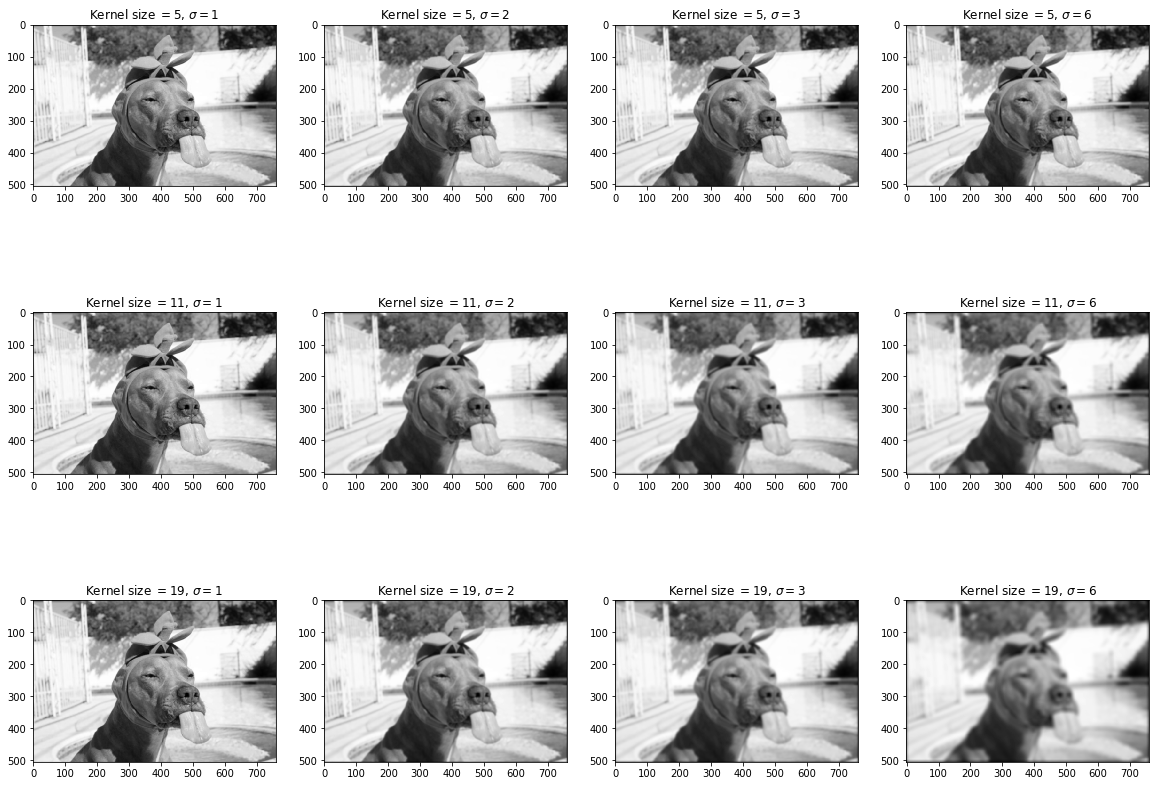

In [4]:
kernel_params = np.array(np.meshgrid([5, 11, 19], [1, 2, 3, 6])).T.reshape([-1, 2])

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
for i, ax in enumerate(axes.reshape(-1)):
  size, sigma = kernel_params[i]
  kernel = GaussianKernel2D(size, sigma)
  result = conv2d(image, kernel, padding="SAME")
  ax.imshow(result, cmap="gray")
  ax.set_title("Kernel size $= {}$, $\sigma = {}$".format(size, sigma))

Now, implement a simple edge detector by first filtering with a Sobel operator and then thresholding the ***RESULT***. How does smoothing the input change the ***RESULT***?

In [5]:
sobel_x = np.array([
  [-1, 0, 1],
  [-2, 0, 2],
  [-1, 0, 1]
])

sobel_y = np.array([
  [-1, -2, -1],
  [0, 0, 0],
  [1, 2, 1]
])

In [6]:
kernel1 = GaussianKernel2D(19, 4)
kernel2 = GaussianKernel2D(19, 6)
image_blur1 = conv2d(image, kernel1, padding="SAME")
image_blur2 = conv2d(image, kernel2, padding="SAME")

Gx_noblur = conv2d(image, sobel_x)
Gy_noblur = conv2d(image, sobel_y)
Gx_sigma1 = conv2d(image_blur1, sobel_x)
Gy_sigma1 = conv2d(image_blur1, sobel_y)
Gx_sigma2 = conv2d(image_blur2, sobel_x)
Gy_sigma2 = conv2d(image_blur2, sobel_y)

We blur the image for different kernels and display the results after convolving with the two Sobel filters, which give us the derivative in $x$ and $y$ direction.

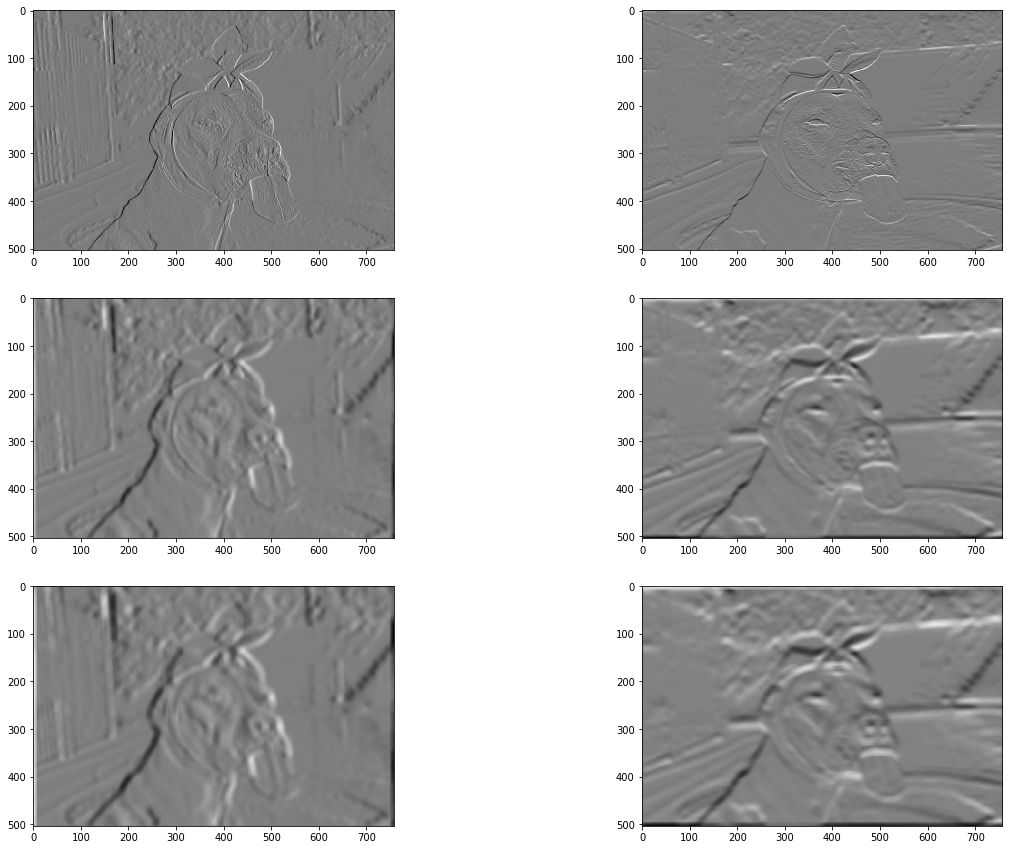

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))
ax[0,0].imshow(Gx_noblur, cmap="gray")
ax[0,1].imshow(Gy_noblur, cmap="gray")
ax[1,0].imshow(Gx_sigma1, cmap="gray")
ax[1,1].imshow(Gy_sigma1, cmap="gray")
ax[2,0].imshow(Gx_sigma2, cmap="gray")
ax[2,1].imshow(Gy_sigma2, cmap="gray")

## Exercise 1.2 Canny Edge Detection

### Preprocessing
If you haven't yet: smooth the image with a Gaussian of your choice. Then use the Sobel operator to create the gradient magnitude and direction matrices (see slides page 23). Round the gradient directions to the 8-neighbor's directions. Display all  intermediate ***RESULT***s!


In [8]:
kernel = GaussianKernel2D(19, 3)
image_blur = conv2d(image, kernel)
Gx_sigma = conv2d(image_blur, sobel_x)
Gy_sigma = conv2d(image_blur, sobel_y)
G = np.sqrt(Gx_sigma**2 + Gy_sigma**2)
Theta = np.arctan2(Gx_sigma, Gy_sigma)

In [9]:
def roundTheta(x, angle=True):
  # Shifts the angle form [-pi, pi] to [0, 2pi] domain and determines what sector it is in
  sector = np.round((np.pi + x) * 4/np.pi) % 8
  if angle:
  # Obtains angle from sector and shifts back
    return sector * np.pi/4 - np.pi
  else:
    return sector

Theta_ = roundTheta(Theta)
Theta_sectors = roundTheta(Theta, angle=False)

In [10]:
def get_topk(img, k):
  topk = np.argpartition(G.flatten(), -k)[-k:]
  return np.array([divmod(i, G.shape[1]) for i in topk])

We plot some of the gradients along the strongest lines, both with 8-neighbour rounding (white) and without:

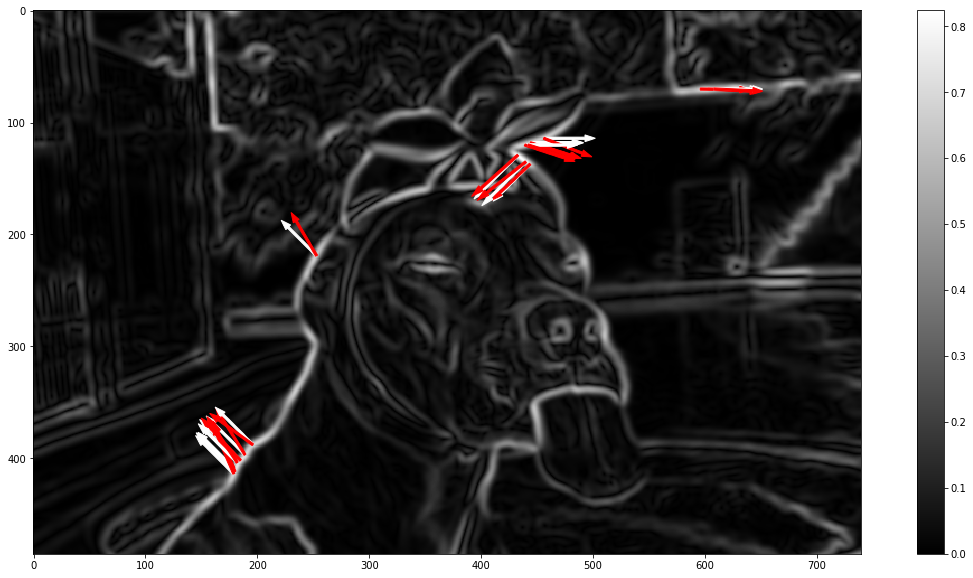

In [11]:
fig, ax = plt.subplots(1, figsize=(20,10))

img = ax.imshow(G, cmap="gray")

k = 400
topk = get_topk(G, 400)
topk_selection = np.random.choice(400, 20, replace=False)
for index in topk[topk_selection]:
  y, x = index
  g, theta, theta_ = 70 * G[y,x], Theta[y,x], Theta_[y,x]
  dx, dy = g * np.cos(theta), g * np.sin(theta)
  dx_, dy_ = g * np.cos(theta_), g * np.sin(theta_)
  arrow = Arrow(x, y, dx, dy, width=10, color='red')
  arrow_ = Arrow(x, y, dx_, dy_, width=10, color='white')
  ax.add_patch(arrow_)
  ax.add_patch(arrow)

plt.colorbar(img,ax=ax)
plt.show()

### Non-Maximum Suppression
Implement the Non-Maximum Suppression step as described in the lecture. Subtract the result from the gradient magnitude image and show the ***RESULT***!

In [12]:
def non_maximum_suppression(img, theta):
  def _get_neighbours(center, subx):
    if (center % 4) == 0:
      return subx[1, 0], subx[1, 2]
    elif (center % 4) == 1:
      return subx[0, 0], subx[2, 2]
    elif (center % 4) == 2:
      return subx[0, 1], subx[2, 1]
    elif (center % 4) == 3:
      return subx[2, 0], subx[0, 2]

  assert img.shape == theta.shape
  height, width = img.shape
  img_ = np.zeros([height + 2, width + 2])
  img_[1:-1, 1:-1] = np.copy(img)

  for x in range(0, width):
    for y in range(0, height):
      subx = img_[y:y+3, x:x+3]
      center = theta[y, x]
      n1, n2 = _get_neighbours(center, subx)
      if img_[y+1, x+1] <= n1 or img_[y+1, x+1] <= n2:
        img_[y+1, x+1] = 0
  return img_[1:-1, 1:-1]

In [13]:
kernel = GaussianKernel2D(7, 3)
image_blur = conv2d(image, kernel)
Gx_sigma = conv2d(image_blur, sobel_x)
Gy_sigma = conv2d(image_blur, sobel_y)
G = np.sqrt(Gx_sigma**2 + Gy_sigma**2)
Theta = np.arctan2(Gx_sigma, Gy_sigma)
Theta_ = roundTheta(Theta)
Theta_sectors = roundTheta(Theta, angle=False)

G_suppressed = non_maximum_suppression(G, Theta_sectors)

Subtracting the gradient after non-maximum suppression from the gradient before non-maximum suppression visualizes the edges that were removed during non-maximum suppression:

Text(0.5, 1.0, 'Edges filtered by non-maximum suppression:')

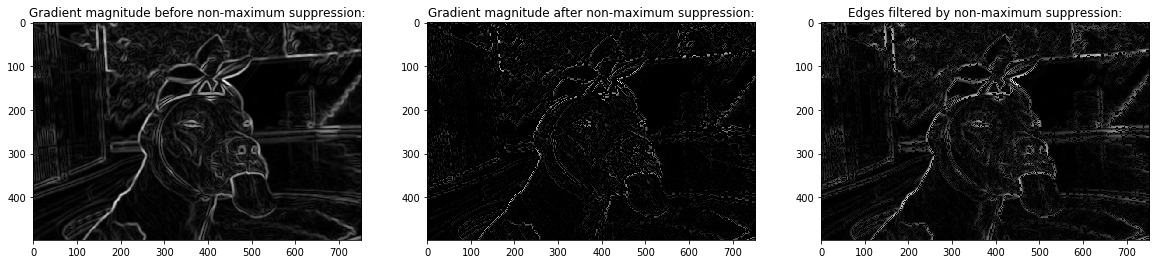

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].imshow(G, cmap="gray")
ax[0].set_title("Gradient magnitude before non-maximum suppression:")
ax[1].imshow(G_suppressed, cmap="gray")
ax[1].set_title("Gradient magnitude after non-maximum suppression:")
ax[2].imshow(G - G_suppressed, cmap="gray")
ax[2].set_title("Edges filtered by non-maximum suppression:")

### Thresholding and Edge Tracing
Implement the edge tracing as described in the lecture and show the final result for three different threshold pairs: two low thresholds (e.g. 20 and 50), high thresholds (e.g. 80 and 120) and thresholds with large spacing (e.g. 40 and 140). (***RESULT***)


In [15]:
def get_edges(G, t1, t2):
  if t2 < t1:
    t1, t2 = t2, t1
  y1, x1 = np.where(np.logical_and(G >= t1, G < t2))
  y2, x2 = np.where(G >= t2)
  weak, strong = np.zeros(G.shape), np.zeros(G.shape)
  weak[y1, x1] = 1
  strong[y2, x2] = 1
  return weak, strong

We take a look at some statistics to determine the optimal thresholds:

In [16]:
print("Minimum:", np.min(G))
print("Maximum:", np.max(G))
print("Mean:", np.mean(G))
print("Median:", np.median(G))
print("Standard deviation:", np.std(G))

Minimum: 0.0
Maximum: 1.223511132538772
Mean: 0.10091187702606959
Median: 0.061534835601222346
Standard deviation: 0.11996248132393902


In [17]:
thresholds = np.array([
  [0.1, 1.0],
  [0.1, 0.5],
  [0.1, 0.3],
  [0.1, 0.2],
])

G_t = []
for t1, t2 in thresholds:
  G_t.append(get_edges(G, t1, t2))

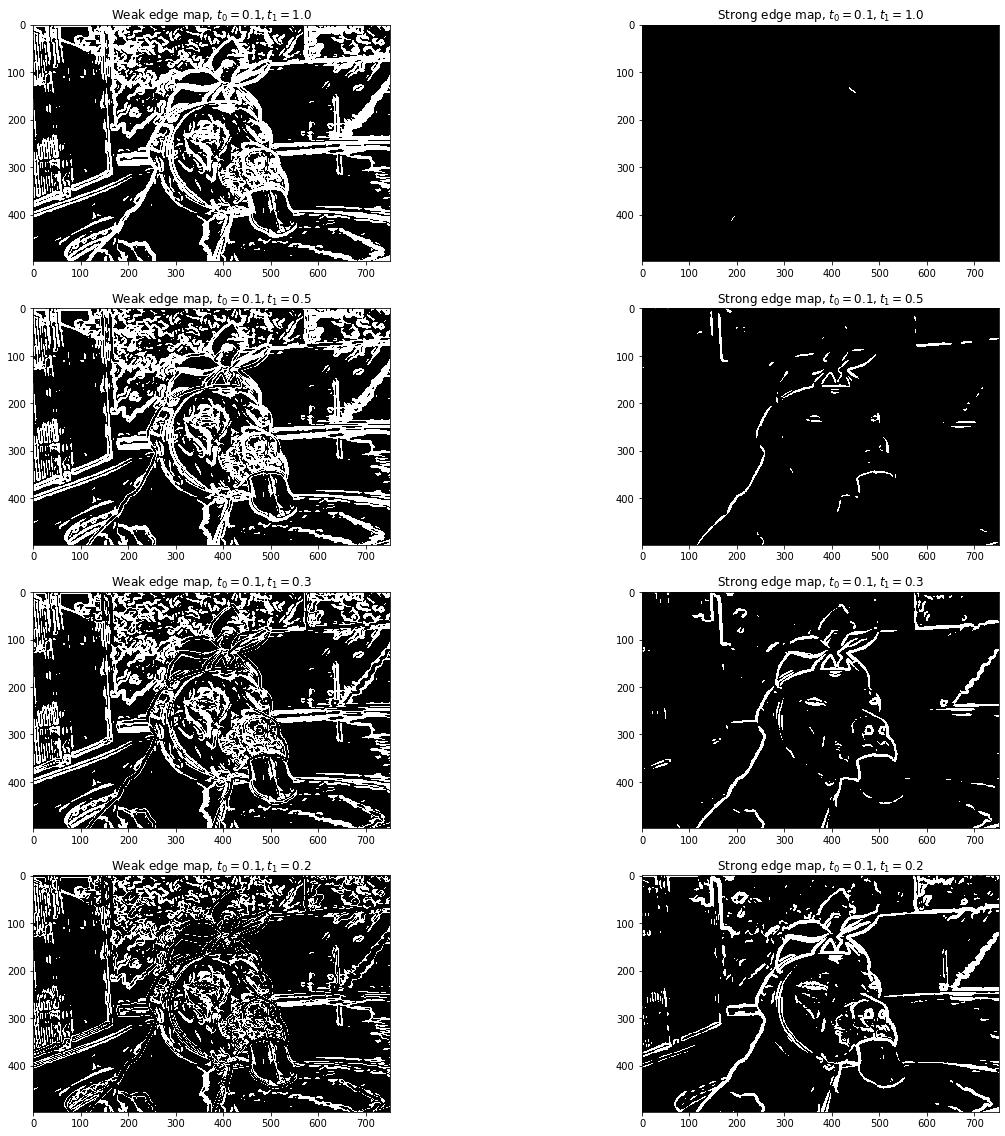

In [18]:
fig, ax = plt.subplots(4, 2, figsize=(20, 20))
for i, maps in enumerate(G_t):
  weak, strong = maps
  ax[i,0].imshow(weak, cmap="gray")
  ax[i,0].set_title("Weak edge map, $t_0 = {}, t_1 = {}$".format(*thresholds[i]))
  ax[i,1].imshow(strong, cmap="gray")
  ax[i,1].set_title("Strong edge map, $t_0 = {}, t_1 = {}$".format(*thresholds[i]))

Note that hysteresis needs to be repeated for all traversation orders in order to ensure that the strong edges are extended with weak edges irrespective of the traversation direction

In [19]:
def hysteresis(weak, strong):
  assert weak.shape == strong.shape
  kernel = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]
  ])

  height, width = strong.shape
  strong_ = np.zeros([height+2, width+2])
  strong_[1:-1, 1:-1] = np.copy(strong)
  
  for x in range(width):
    for y in range(height):
      if weak[y,x] and np.any(np.multiply(strong_[y:y+3, x:x+3], kernel)):
        strong_[y, x] = 1

  for x in range(width):
    for y in range(height-1, -1, -1):
      if weak[y,x] and np.any(np.multiply(strong_[y:y+3, x:x+3], kernel)):
        strong_[y, x] = 1

  for x in range(width-1, -1, -1):
    for y in range(height):
      if weak[y,x] and np.any(np.multiply(strong_[y:y+3, x:x+3], kernel)):
        strong_[y, x] = 1

  for x in range(width-1, -1, -1):
    for y in range(height-1, -1, -1):
      if weak[y,x] and np.any(np.multiply(strong_[y:y+3, x:x+3], kernel)):
        strong_[y, x] = 1

  return strong_[1:-1, 1:-1]

We visualize the result of hysteresis for the 3rd threshold pair:

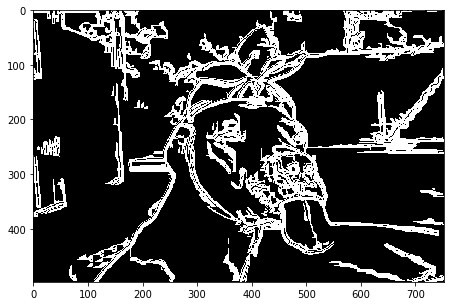

In [20]:
edges3 = hysteresis(*G_t[2])

fig, ax = plt.subplots(1, figsize=(20, 5))
ax.imshow(edges3, cmap="gray")

Finally, we put all together:

In [21]:
def canny(img, smooth_size, sigma, t1, t2):
  kernel = GaussianKernel2D(smooth_size, sigma)
  img_blur = conv2d(img, kernel)
  Gx = conv2d(img_blur, sobel_x)
  Gy = conv2d(img_blur, sobel_y)
  G = np.sqrt(Gx**2 + Gy**2)
  Theta = np.arctan2(Gx, Gy)
  Theta_sectors = roundTheta(Theta, angle=False)

  G_suppressed = non_maximum_suppression(G, Theta_sectors)
  weak, strong = get_edges(G_suppressed, t1, t2)
  edges = hysteresis(weak, strong)
  return edges

And perform canny edge detection on the image with suitable kernel size, standard deviation $\sigma$ and thresholds:

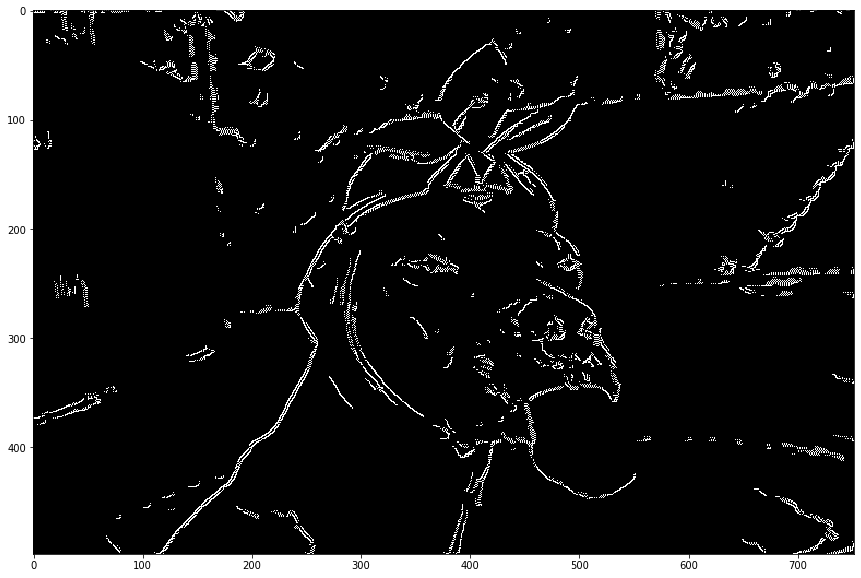

In [22]:
canny_edges = canny(image, 7, 2, 0.2, 0.3)
fig, ax = plt.subplots(1, figsize=(20, 10))
ax.imshow(canny_edges, cmap="gray")
plt.show()